In [127]:
#Importing Libraries
from matplotlib import pyplot as plt
import numpy as np
import csv
import pandas as pd
import scipy.spatial
import random
from sklearn.neighbors import KNeighborsClassifier
import pickle
import scikitplot as skplt
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import json
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import math 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error 
from regressors import stats
import scipy.stats as st
from sklearn import linear_model
from sklearn.linear_model import RidgeCV, LassoCV, LogisticRegression, LogisticRegressionCV, RidgeClassifier, Lasso
from IPython.display import Image
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

Part (b) Load the training set into a matrix X:

(540, 2500) (540,)


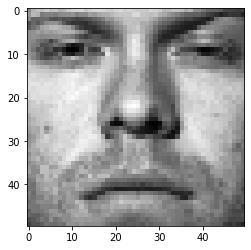

In [3]:
import numpy as np
from scipy import misc
from matplotlib import pylab as plt
import matplotlib.cm as cm
import imageio
# pip install imageio

%matplotlib inline

train_labels, train_data = [], []
for line in open('./faces/train.txt'):
    im = imageio.imread(line.strip().split()[0])
    train_data.append(im.reshape(2500,))
    train_labels.append(line.strip().split()[1])
train_data, train_labels = np.array(train_data, dtype=float), np.array(train_labels, dtype=int)

print(train_data.shape, train_labels.shape)
plt.imshow(train_data[10, :].reshape(50,50), cmap = cm.Greys_r)
plt.show()

Read In Test Data

(100, 2500) (100,)


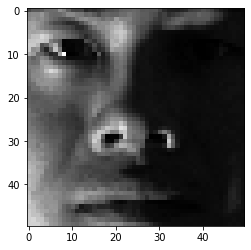

In [136]:
test_labels, test_data = [], []
for line in open('./faces/test.txt'):
    im = imageio.imread(line.strip().split()[0])
    test_data.append(im.reshape(2500,))
    test_labels.append(line.strip().split()[1])
test_data, test_labels = np.array(test_data, dtype=float), np.array(test_labels, dtype=int)

print(test_data.shape, test_labels.shape)
plt.imshow(test_data[10, :].reshape(50,50), cmap = cm.Greys_r)
plt.show()

Part (c) Average Face.

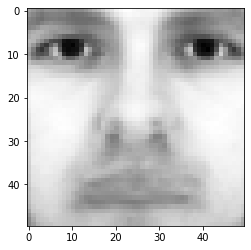

In [4]:
avg_face = []
for elem in range(len(train_data[0])):
    elm_avg = []
    for row in train_data:
        elm_avg.append(row[elem])
    new_elm = float(sum(elm_avg))/len(elm_avg)
    avg_face.append(new_elm)
    
avg_face = np.array(avg_face)

plt.imshow(avg_face.reshape(50,50), cmap = cm.Greys_r)
plt.show()

Part (d) Mean  Subtraction.

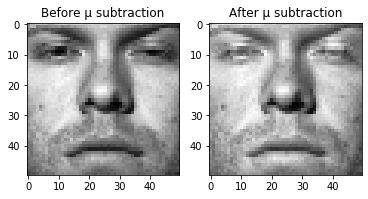

In [5]:
train_data_u = []
for faces in train_data:
    x_u = np.subtract(faces,avg_face)
    train_data_u.append(x_u)
   
plt.subplot(1, 2, 1).set_title("Before μ subtraction")
plt.imshow(train_data[10].reshape(50,50), cmap = cm.Greys_r)

plt.subplot(1, 2, 2).set_title("After μ subtraction")
plt.imshow(train_data_u[10].reshape(50,50), cmap = cm.Greys_r)
plt.show()

Part (e) Eigenface.

In [6]:
U, E, Vi = np.linalg.svd(train_data)

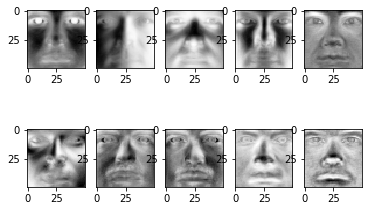

In [7]:
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(Vi[i].reshape(50,50), cmap = cm.Greys_r)
plt.show()

Part (f) Low-rank Approximation.

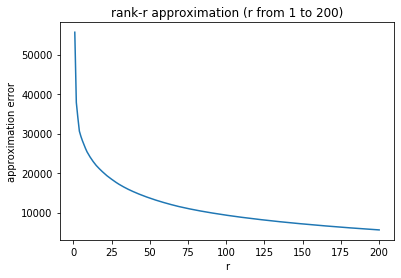

In [32]:
from scipy import linalg

U, E, Vi = np.linalg.svd(train_data)

E = linalg.diagsvd(E, train_data.shape[0], train_data.shape[1])

def low_rank_approx(SVD, X, r):
    u, s, v = SVD
    X_hat = np.dot(np.dot(u[:, :r], s[:r, :r]), v[:r, :])
    return np.linalg.norm((X - X_hat), 'fro')

y = []
x = range(1, 201)
for r in x:
    y.append(low_rank_approx((U, E, Vi), train_data, r))
    
plt.title("rank-r approximation")
plt.xlabel("r")
plt.ylabel("approximation error")
plt.plot(x, y)
plt.show()

Part (g) Eigenface Feature.

In [78]:
from scipy import linalg

U, E, Vi = np.linalg.svd(train_data)
E = linalg.diagsvd(E, train_data.shape[0], train_data.shape[1])

Ut, Et, Vit = np.linalg.svd(test_data)
Et = linalg.diagsvd(Et, test_data.shape[0], test_data.shape[1])

def eigenface_feature(SVD, X, r):
    u, s, v = SVD
#     X_hat = np.dot(np.dot(u[:, :r], s[:r, :r]), v[:r, :])
    F = np.dot(X, v[:r, :].transpose())
    
    return F

r = 2

F_train_shape = eigenface_feature((U, E, Vi), train_data, r).shape
F_test_shape = eigenface_feature((Ut, Et, Vit), test_data, r).shape

F_train_shape, F_test_shape

((540, 2), (100, 2))

Part (h) Face Recognition

In [123]:
#Setup F
r = 10
F_train = eigenface_feature((U, E, Vi), train_data, r)
F_test = eigenface_feature((Ut, Et, Vit), test_data, r)

#Train
lreg = LogisticRegression(random_state=0).fit(F_train, train_labels)
x_train_score = lreg.score(F_train, train_labels)
print("train score: {}%".format(round(x_train_score*100, 2)))

#Test
y_pred = lreg.predict(F_test)
x_test_score = lreg.score(F_test, test_labels)
print("test score: {}%".format(round(x_test_score*100, 2)))

train score: 84.63%
test score: 3.0%


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


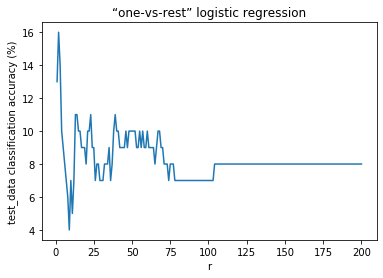

In [135]:
def face_rec(r):
    F_train = eigenface_feature((U, E, Vi), train_data, r)
    F_test = eigenface_feature((Ut, Et, Vit), test_data, r)

    ovr_reg = OneVsRestClassifier(SVC()).fit(F_train, train_labels)
    x_test_score = ovr_reg.score(F_test, test_labels)

    return x_test_score*100

y = []
x = range(1, 201)
for r in x:
    y.append(face_rec(r))
    
plt.title('“one-vs-rest” logistic regression')
plt.xlabel("r")
plt.ylabel("test_data classification accuracy (%)")
plt.plot(x, y)
plt.show()

In [ ]:
# train_path = "train.csv"
# test_path = "test.csv"

# df_train = pd.read_csv(train_path)
# df_test = pd.read_csv(test_path)
# # df_train.head()
# # Image(filename=df_train[0]) 
# pic = df_train['path'][55]
# Image(filename=pic[8:], width = 150) 

# def top_r_eigenfaces(n, X_train, X_test):
#     U, E, Vi = X_train
#     Ut, Et, Vit = X_test
#     F_train = []
#     F_test = []
#     x = range(1, n)

#     for r in x:
#         F_train.append(eigenface_feature((U, E, Vi), train_data, r))
#         F_test.append(eigenface_feature((Ut, Et, Vit), test_data, r))
        
#     return F_train, F_test

# top_r_eigenfaces(10, (U, E, Vi), (Ut, Et, Vit))[0]

# print(F_train, F_test)

# a = 0
# for i in range(len(test_labels)):
#     if test_labels[i] == y_pred[i]:
#         a += 1
#     else:
#         pass

# accuracy = a/len(test_labels)*100
# print("test score: {}%".format(accuracy))